# Titanic Survival Prediction with ML Pipelines

*A comprehensive practice project demonstrating pipeline construction, hyperparameter tuning, and model comparison.*

## Project Overview

This notebook builds a classification pipeline to predict Titanic passenger survival using:
- **Automated preprocessing** for numerical and categorical features
- **GridSearchCV** for hyperparameter optimization
- **Model comparison** between Random Forest and Logistic Regression
- **Feature importance analysis** to interpret predictions

## Import Libraries

In [1]:
# Core data science stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Load and Explore Data

In [2]:
# Load Titanic dataset from seaborn
titanic = sns.load_dataset('titanic')
print(f"Dataset shape: {titanic.shape}")
display(titanic.head())

Dataset shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Data Dictionary

| Variable | Definition |
|:---------|:-----------|
| survived | Survived? (0 = No, 1 = Yes) |
| pclass | Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd) |
| sex | Sex (male/female) |
| age | Age in years |
| sibsp | # of siblings/spouses aboard |
| parch | # of parents/children aboard |
| fare | Passenger fare |
| class | Ticket class (object) |
| who | man, woman, or child |
| adult_male | True/False |
| alone | True/False |

## Feature Selection and Target Definition

In [3]:
# Select features (dropping columns with excessive missing data or low relevance)
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = titanic[features]
y = titanic[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (891, 10)
Target shape: (891,)


## Check Class Balance

In [4]:
# Calculate survival percentages
survival_pct = y.value_counts(normalize=True).mul(100).round(2)
print("Class distribution:")
print(survival_pct)
print(f"\nDataset shows ~{survival_pct[1]:.1f}% survival rate")
print("⚠️  Class imbalance detected → use stratified splitting and cross-validation")

Class distribution:
survived
0    61.62
1    38.38
Name: proportion, dtype: float64

Dataset shows ~38.4% survival rate
⚠️  Class imbalance detected → use stratified splitting and cross-validation


## Train-Test Split with Stratification

In [5]:
# Split data while preserving class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 80/20 split
    stratify=y,           # Maintain 38/62 survival ratio in both sets
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 712 samples
Test set: 179 samples


## Define Preprocessing Pipelines

In [6]:
# Automatically detect column types
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical features: ['sex', 'class', 'who', 'adult_male', 'alone']


### Numerical Transformer
**Purpose:** Handle missing values and standardize scale for distance-based algorithms.

In [7]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing with column median
    ('scaler', StandardScaler())                     # Normalize to mean=0, std=1
])

### Categorical Transformer
**Purpose:** Handle missing categories and convert text to binary features.

In [8]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Convert to binary columns
])

### Combine Transformers
**Purpose:** Apply appropriate preprocessing to each column type.

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Build Complete Pipeline (Preprocessing + Model)

In [10]:
# Create pipeline that chains preprocessing and classification
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

## Hyperparameter Tuning with GridSearchCV

In [11]:
# Define search space for Random Forest hyperparameters
param_grid = {
    'classifier__n_estimators': [50, 100],           # Number of trees
    'classifier__max_depth': [None, 10, 20],         # Tree depth limit
    'classifier__min_samples_split': [2, 5]          # Min samples to split node
}

# Use stratified k-fold to preserve class distribution in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,                    # 5-fold stratified cross-validation
    scoring='accuracy',       # Optimize for classification accuracy
    verbose=2,                # Print progress
    n_jobs=-1                 # Use all CPU cores
)

## Train Model with Grid Search

In [12]:
# Fit grid search (this will train 12 configurations × 5 folds = 60 models)
grid_search.fit(X_train, y_train)

# Extract best model and parameters
best_rf_model = grid_search.best_estimator_
print(f"\nBest CV accuracy: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   

## Evaluate on Test Set

In [13]:
# Generate predictions
y_pred_rf = best_rf_model.predict(X_test)

# Print classification metrics
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Did not survive', 'Survived']))

# Calculate test accuracy
test_accuracy = best_rf_model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_accuracy:.2%}")

Random Forest Classification Report:
                 precision    recall  f1-score   support

Did not survive       0.81      0.86      0.84       110
       Survived       0.76      0.68      0.72        69

       accuracy                           0.79       179
      macro avg       0.79      0.77      0.78       179
   weighted avg       0.79      0.79      0.79       179


Test set accuracy: 79.33%


## Visualize Confusion Matrix

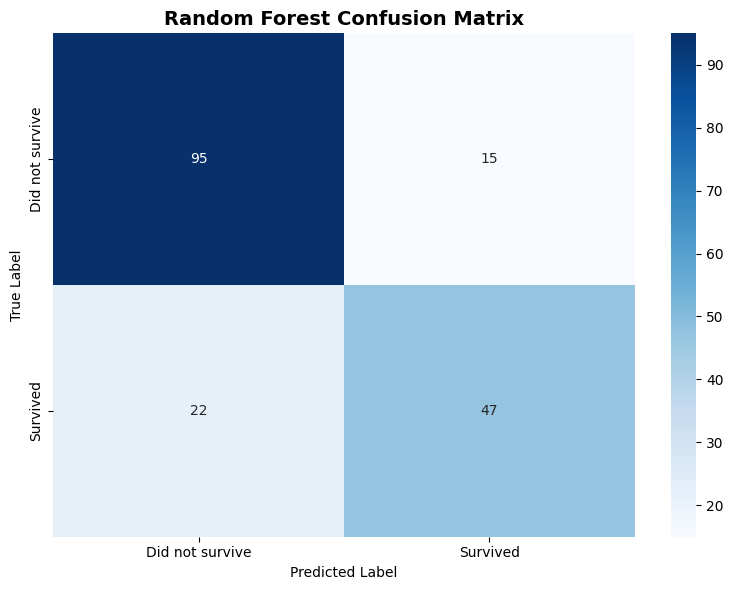

In [14]:
# Generate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Did not survive', 'Survived'],
            yticklabels=['Did not survive', 'Survived'])
plt.title('Random Forest Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Feature Importance Analysis

In [15]:
# Extract feature importances from trained Random Forest
feature_importances = best_rf_model.named_steps['classifier'].feature_importances_

# Get one-hot encoded categorical feature names
categorical_encoded = (best_rf_model.named_steps['preprocessor']
                       .named_transformers_['cat']
                       .named_steps['onehot']
                       .get_feature_names_out(categorical_features))

# Combine all feature names
all_feature_names = numerical_features + list(categorical_encoded)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

### Plot Feature Importances

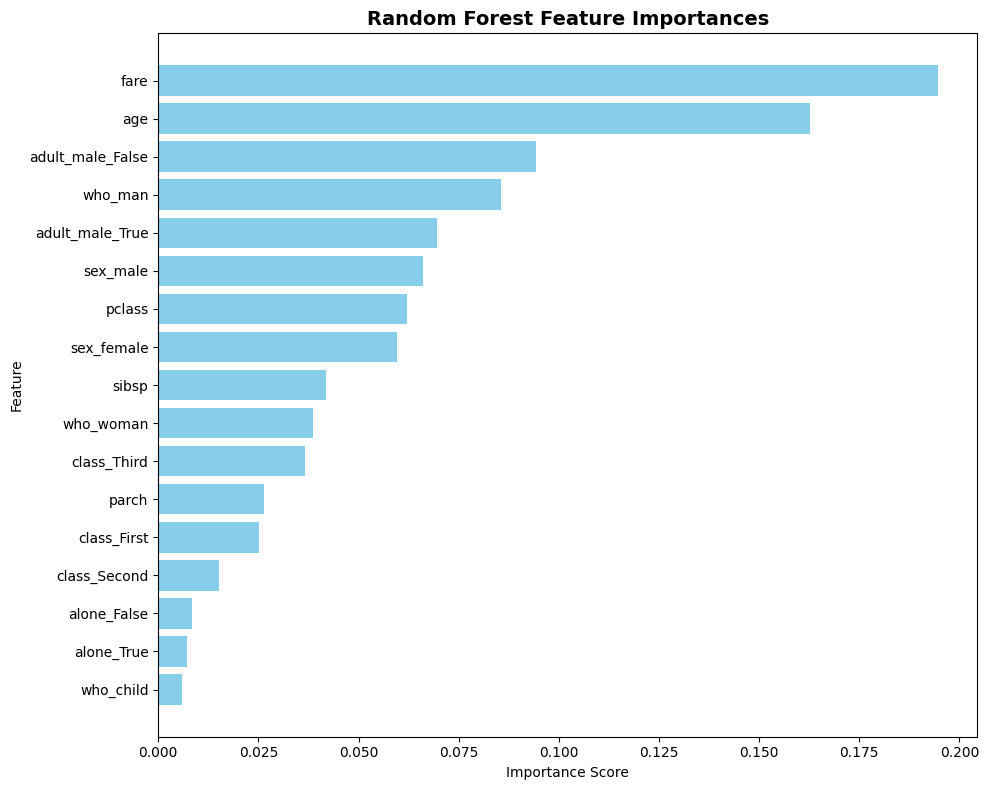


Top 5 most important features:
             Feature  Importance
4               fare    0.194776
1                age    0.162703
13  adult_male_False    0.094204
11           who_man    0.085649
14   adult_male_True    0.069583


In [16]:
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(importance_df.head())

## Compare with Logistic Regression

In [17]:
# Create new pipeline with Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Define new parameter grid for Logistic Regression
lr_param_grid = {
    'classifier__solver': ['liblinear'],           # Solver for small datasets
    'classifier__penalty': ['l1', 'l2'],           # Regularization type
    'classifier__C': [0.1, 1.0, 10.0],            # Inverse regularization strength
    'classifier__class_weight': [None, 'balanced'] # Handle class imbalance
}

# Initialize new grid search
lr_grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

## Train Logistic Regression Model

In [18]:
# Fit grid search for Logistic Regression
lr_grid_search.fit(X_train, y_train)

# Extract best model
best_lr_model = lr_grid_search.best_estimator_
print(f"\nBest CV accuracy: {lr_grid_search.best_score_:.4f}")
print(f"Best parameters: {lr_grid_search.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classi

## Evaluate Logistic Regression on Test Set

In [19]:
# Generate predictions
y_pred_lr = best_lr_model.predict(X_test)

# Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Did not survive', 'Survived']))

# Calculate test accuracy
lr_test_accuracy = best_lr_model.score(X_test, y_test)
print(f"\nTest set accuracy: {lr_test_accuracy:.2%}")

Logistic Regression Classification Report:
                 precision    recall  f1-score   support

Did not survive       0.84      0.89      0.87       110
       Survived       0.81      0.74      0.77        69

       accuracy                           0.83       179
      macro avg       0.83      0.82      0.82       179
   weighted avg       0.83      0.83      0.83       179


Test set accuracy: 83.24%


## Visualize Logistic Regression Confusion Matrix

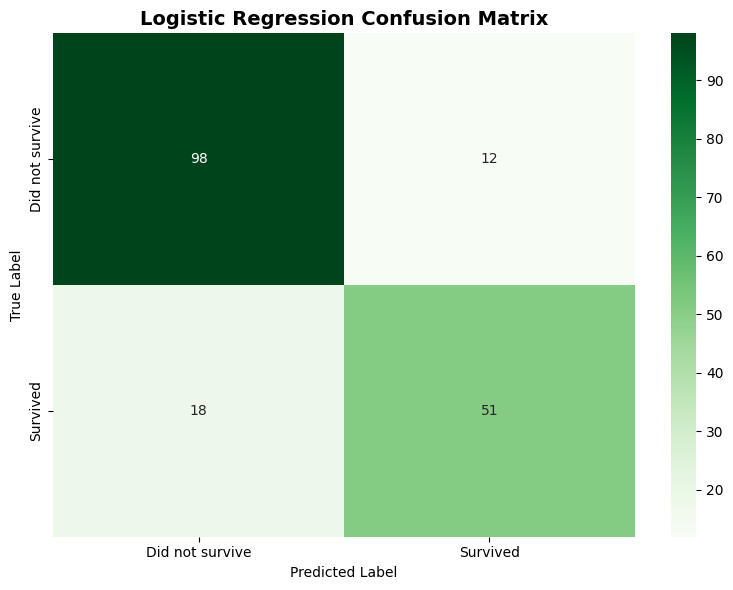

In [20]:
# Generate confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Did not survive', 'Survived'],
            yticklabels=['Did not survive', 'Survived'])
plt.title('Logistic Regression Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Logistic Regression Coefficients

In [21]:
# Extract coefficients from trained Logistic Regression
coefficients = best_lr_model.named_steps['classifier'].coef_[0]

# Create coefficient DataFrame (use same feature names as Random Forest)
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute value

### Plot Coefficient Magnitudes

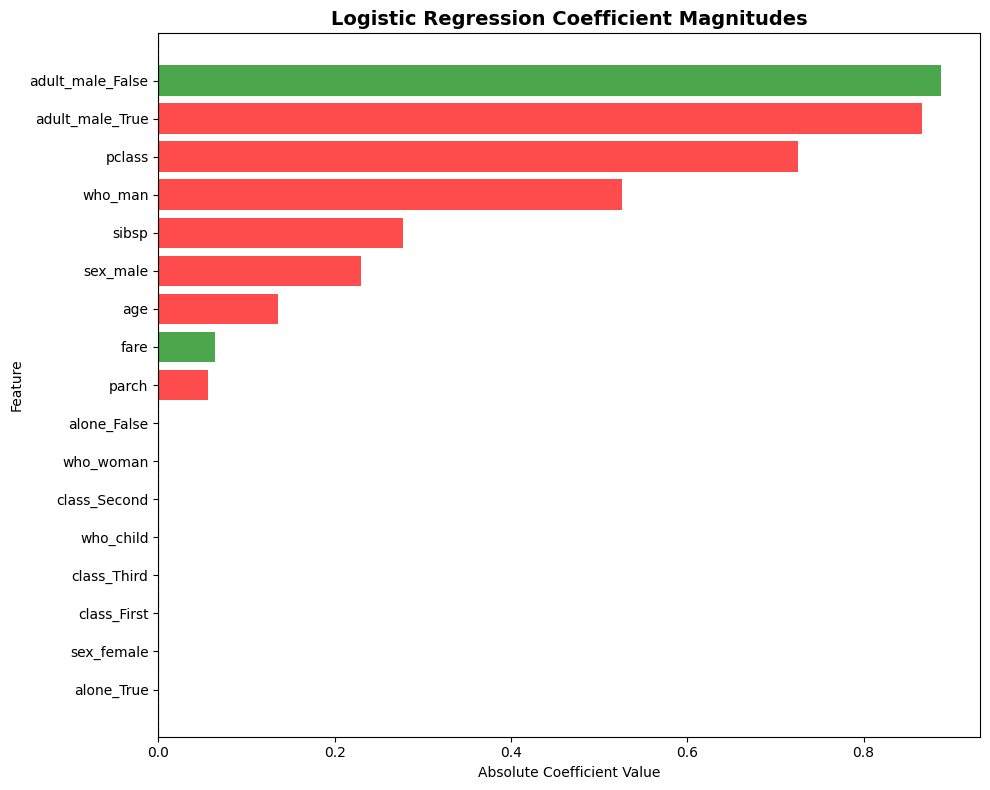


Top 5 features by coefficient magnitude:
             Feature  Coefficient
13  adult_male_False     0.887685
14   adult_male_True    -0.866023
0             pclass    -0.725205
11           who_man    -0.525896
2              sibsp    -0.277279


In [22]:
plt.figure(figsize=(10, 8))
colors = ['green' if c > 0 else 'red' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'].abs(), color=colors, alpha=0.7)
plt.gca().invert_yaxis()
plt.title('Logistic Regression Coefficient Magnitudes', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nTop 5 features by coefficient magnitude:")
print(coef_df.head())

## Model Comparison Summary

In [23]:
# Create comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'CV Accuracy': [grid_search.best_score_, lr_grid_search.best_score_],
    'Test Accuracy': [test_accuracy, lr_test_accuracy]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))
print("="*60)


MODEL COMPARISON
              Model  CV Accuracy  Test Accuracy
      Random Forest     0.841308       0.793296
Logistic Regression     0.818842       0.832402


## Key Takeaways

### What I Learned:
1. **Pipelines prevent leakage**: By bundling preprocessing with the model, each CV fold applies transformations consistently.
2. **Stratification is crucial**: With 38/62 class imbalance, stratified splitting preserves proportions in train/test/CV folds.
3. **Feature interpretability differs**: Random Forest uses Gini importance, while Logistic Regression shows linear coefficients—different perspectives on the same data.
4. **Hyperparameter tuning matters**: GridSearchCV systematically explores parameter combinations to find optimal configurations.
5. **Model comparison reveals trade-offs**: Both models achieved similar accuracy, but feature importance rankings diverged, suggesting further correlation analysis is needed.

### Next Steps:
- Analyze feature correlations to understand redundancy (e.g., `sex_male` vs `who_man`)
- Try ensemble methods like Gradient Boosting or XGBoost
- Engineer new features (e.g., family size = `sibsp` + `parch`)
- Investigate class weights or SMOTE for imbalance handling